In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from utils.analysis_helpers import *

# Overview of topics per Experiment

In [16]:
df = pd.read_csv('./topics/df_topic_Compassion.csv')

# Palette for the topics
unique_topics = df['one_topic'].unique()
cmap = plt.get_cmap('tab20', len(unique_topics))
palette = {topic: mcolors.to_hex(cmap(i)) for i, topic in enumerate(sorted(unique_topics))}

In [4]:
df.head(2)

,File Name,turn_index,Content,preprocessed_content,Experiment,Condition,Id,Speaker,one_topic,one_topic_name,multiple_topics,multiple_topics_name
0,ID 05,1,"so, that was very, let's say, unexpected and s...",let unexpected surprising moment go realize ge...,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[0],['0_body_myself_touch_focus']
1,ID 05,3,"a little bit it was a little bit like, okay, w...",watch outside special give lot emotion explain...,OBE1,1,5,Participant,0,0_body_myself_touch_focus,[0],['0_body_myself_touch_focus']


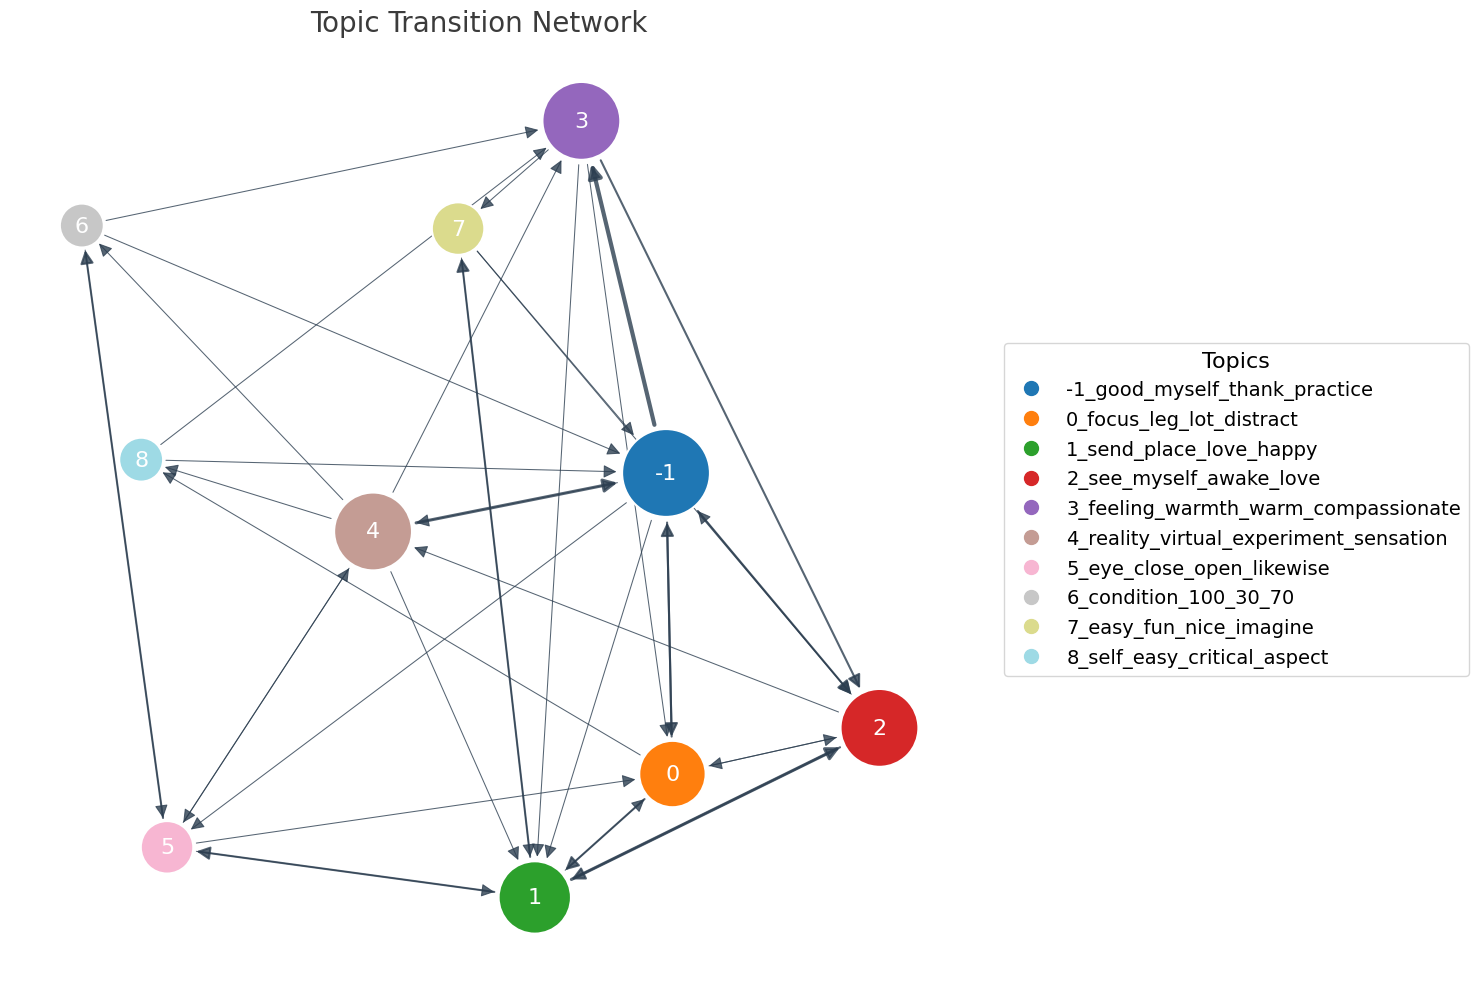

In [ ]:
G = build_network_from_interviews(df, include_self_loops=False)
plot_topic_transition_network(G, show_edge_labels=False, palette=palette, size_by="appearance", file_name="outputs/images/network.png") 
# size_by= appearance , occurrence, degree_centrality

In [6]:
# for file in df["File Name"].unique():
#     print(file)
#     G_single = build_network_from_interviews(df[df["File Name"] == file], include_self_loops=False)
#     plot_topic_transition_network(G_single, show_edge_labels=True,palette=palette, size_by="occurrence")

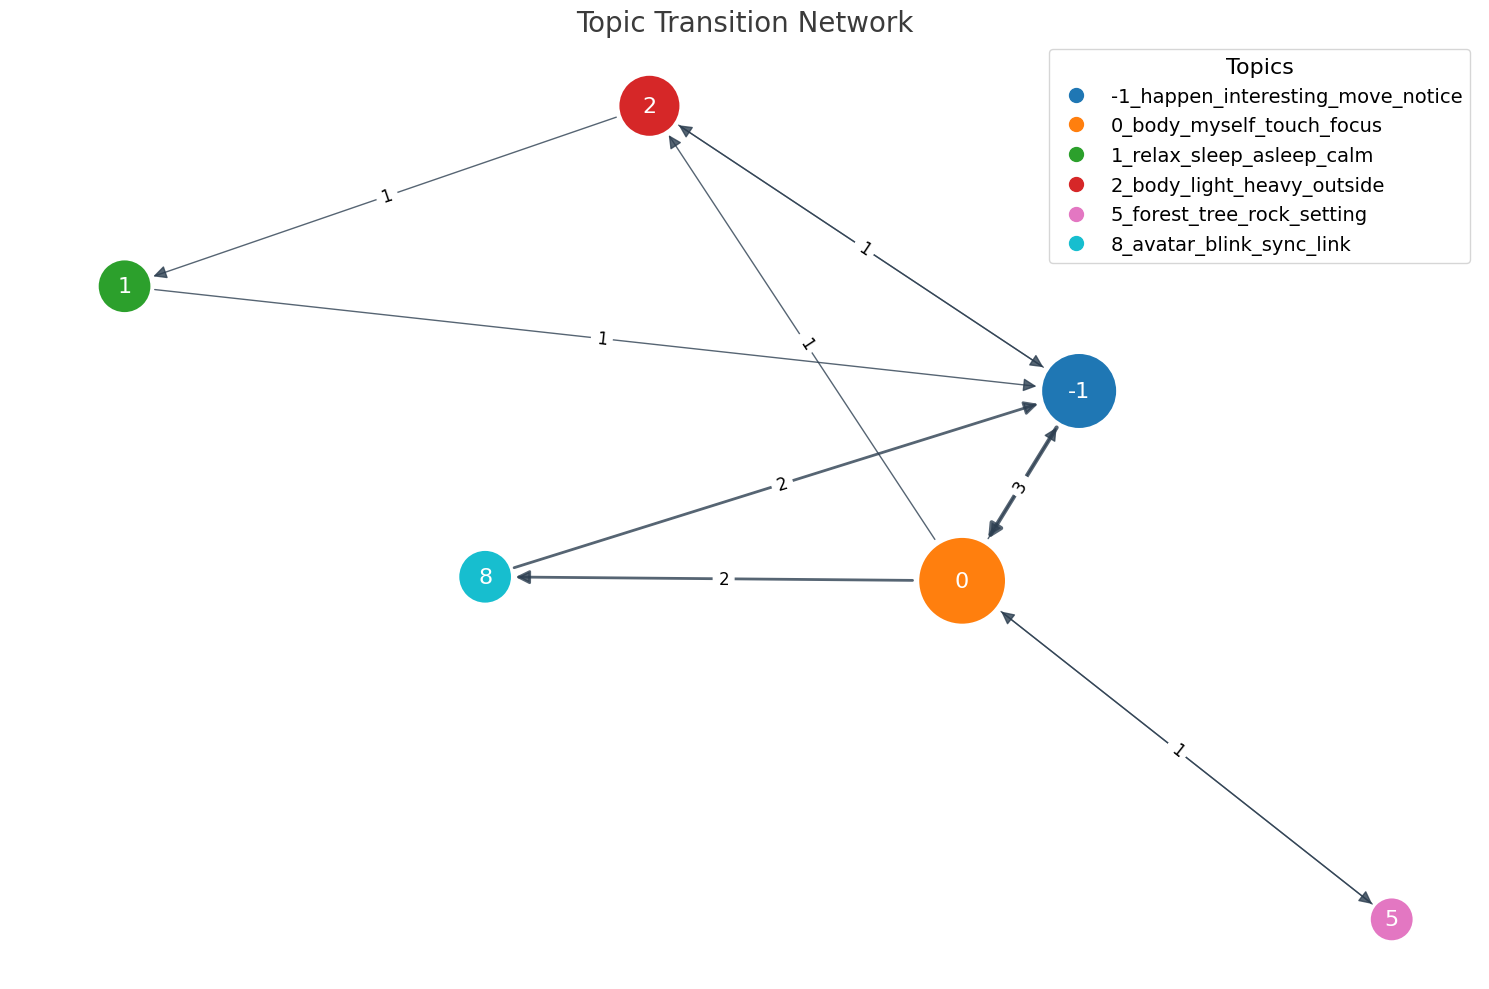

In [7]:
G_single = build_network_from_interviews(df[df["File Name"] == "S230 intervention"], include_self_loops=False)
plot_topic_transition_network(G_single, show_edge_labels=True,palette=palette, size_by="occurrence")

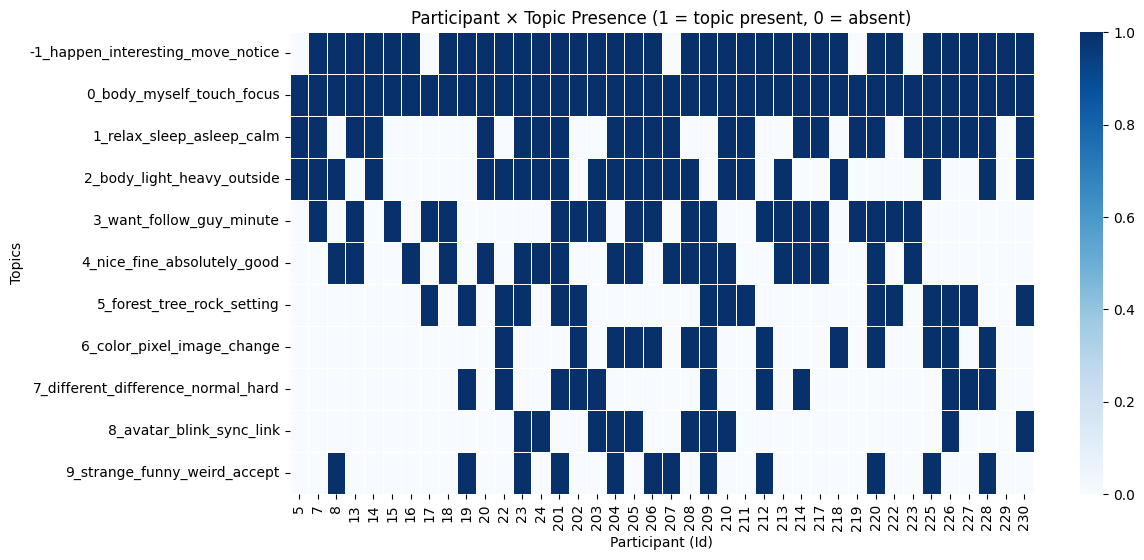

In [9]:
# 1. Count occurrences of each topic by participant
participant_topic_counts = (
    df.groupby(["Id", "one_topic_name"])["Content"]
    .size()
    .reset_index(name="Count")
)

# 2. Convert any Count > 0 to presence = 1
participant_topic_counts["Presence"] = (participant_topic_counts["Count"] > 0).astype(int)

# 3. Pivot to create a presence matrix
presence_matrix = participant_topic_counts.pivot(
    index="one_topic_name", 
    columns="Id", 
    values="Presence"
).fillna(0)

# 4. Visualize as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    presence_matrix, 
    cmap="Blues", 
    linewidths=.5,
)
plt.title("Participant × Topic Presence (1 = topic present, 0 = absent)")
plt.ylabel("Topics")
plt.xlabel("Participant (Id)")
plt.show()

<Axes: xlabel='File Name'>

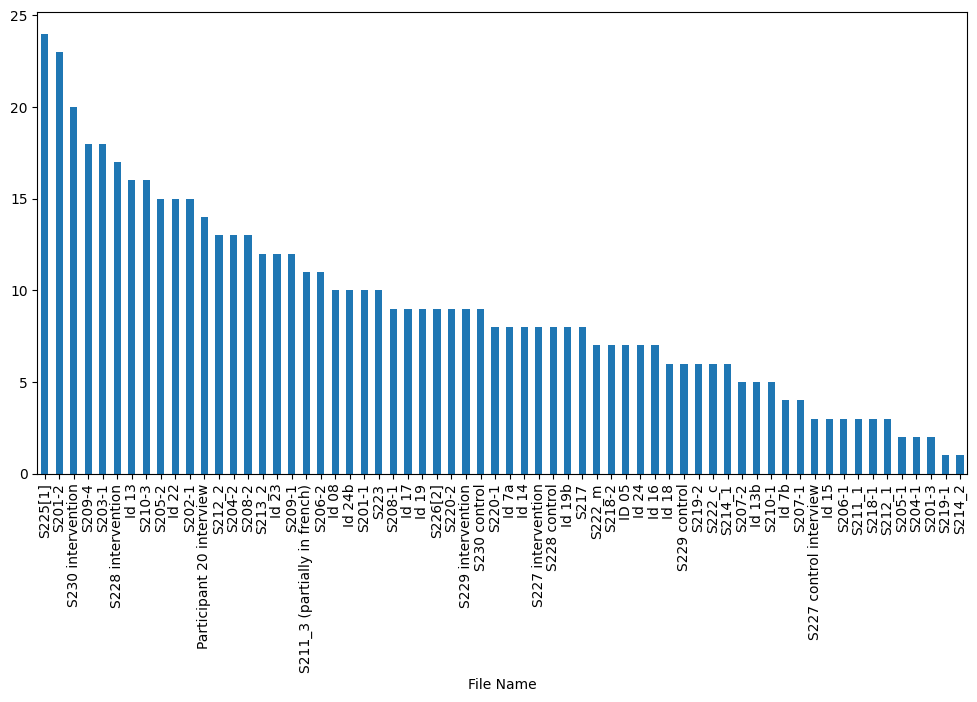

In [10]:
# Number of turn by file name (interview)
df["File Name"].value_counts().plot(kind="bar", figsize=(12, 6))

# Specifcs topic Analysis

In [4]:
def tag_topic(df, id_topic, exclude_indices, name_tag, multiple=False):
    single_topic_rows = df[df['one_topic'] == id_topic]
    multiple_topic_rows = df[df['multiple_topics'].map(lambda x: id_topic in x)]
    # Identify indices to tag from single topic or topics distribution
    rows_to_tag = single_topic_rows[~single_topic_rows.index.isin(exclude_indices)]
    if multiple:
        rows_to_tag = multiple_topic_rows[~multiple_topic_rows.index.isin(exclude_indices)]

    # Apply the tag
    df.loc[rows_to_tag.index, "tag"] = name_tag

def influence_analysis(topic_rows, tag_name):
    topic_rows = df[df['tag'] == tag_name]
    first_mentions = (
        topic_rows
        .sort_values(by='turn_index')
        .groupby('File Name', group_keys=False)
        .head(1)
        .reset_index(drop=True)
    )

    # Get participant IDs who mentioned the topic
    participant_rows = topic_rows[topic_rows['Speaker'] == 'Participant']
    participant_ids = participant_rows['Id'].unique()
    n_participants = len(participant_ids)

    # Find files where the Interviewer mentioned the topic first
    files_with_interviewer_first = first_mentions[first_mentions['Speaker'] == 'Interviewer']['File Name']

    # Count participants influenced by the Interviewer's first mention
    influenced_participants = participant_rows[
        participant_rows['File Name'].isin(files_with_interviewer_first)
    ]['Id'].unique()
    m_feedback = len(influenced_participants)

    # Print results
    print(f"Number of participants who mentioned the topic: {n_participants}")
    print(f"Participants who mentioned the topic: {list(participant_ids)}")

    print(f"Number of participants influenced by Interviewer mentioning the topic first: {m_feedback}")
    print(f"Participants influenced by Interviewer's first mention: {list(influenced_participants)}")

In [24]:
import ast

df = pd.read_csv("./topics/df_warm_tagged.csv")
# Re-convert 'multiple_topics' column strings to lists (lost during saving)
df['multiple_topics'] = df['multiple_topics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df.head(2)

,Experiment,File Name,Id,Content Type,Start Time,End Time,Speaker,Content,Condition,Order Condition,turn_index,Speaker_original,preprocessed_content,one_topic,one_topic_name,multiple_topics,multiple_topics_name,multiple_topics_list,Index,tag
0,Compassion,S301final,301,Audio,"00:00:00,060","00:00:12,100",Interviewer,And you can just a little bit tell about your ...,1,Unknown,0,Interviewer 1,tell experience section relax follow say help,17,17_experience_share_spot_problem,"[1, 8, 17]","['1_meditation_relax_guide_enjoy', '8_follow_g...","['1_meditation_relax_guide_enjoy', '8_follow_g...",0,NaN
1,Compassion,S301final,301,Audio,"00:00:12,320",00:00:23,Interviewer,There is no wrong or right to just saying your...,1,Unknown,1,Interviewer 2,wrong right say experience nice problem,17,17_experience_share_spot_problem,"[17, 31]","['17_experience_share_spot_problem', '31_corre...","['17_experience_share_spot_problem', '31_corre...",1,NaN


In [13]:
df.one_topic_name.unique()

array(['0_myself_body_reality_virtual', '-1_look_hand_eye_head',
       '1_touch_delay_scene_image', '6_body_half_phrase_hard',
       '24_comfortable_sit_confortable_cushion',
       '2_eye_open_close_condition', '13_strange_funny_weird_accept',
       '23_quickly_happen_drop_dealaye', '31_heavy_light_weight_heavier',
       '28_absolutely_probable_definitely_positive',
       '5_platform_voice_rock_feedback', '12_easy_fun_free_nice',
       '25_fine_good_wow_ok', '34_moment_jar_instructive_affraid',
       '15_100_10_80_75', '7_want_follow_fell_resistance',
       '21_relief_relax_relaxed_release', '33_calm_peaceful_body_',
       '22_interesting_publish_knock_observe',
       '16_strange_scary_discomfort_fully',
       '14_connect_zoom_disconnect_link', '9_happy_long_day_mental',
       '4_forest_rock_river_indonesia', '32_float_reach_level_foot',
       '3_leg_focus_concentrate_distract',
       '27_expect_train_platform_scene', '11_fall_sleep_asleep_sleepy',
       '8_normal_diffe

## Tag

In [ ]:
df["tag"] = None

### Index to select for tagging

In [20]:
list_index = [10,11,336,337,338,571,339,345,401]
df.loc[list_index, "tag"] = "heavy_light"

### Select all row from one topic minus some exclusion (after manual revision)

In [15]:
id_topic = 18
exclude_indices = [666]
tag_topic(df, id_topic, exclude_indices, "floating", multiple=False)

## Analyse the tagged data

In [22]:
df.tag.unique()

array([nan, 'heavy_light', 'floating', 'sleep', 'pixel_avatar'],
      dtype=object)

In [25]:
# Filter rows by tag
tag_name = "warm"
influence_analysis(df, tag_name)

Number of participants who mentioned the topic: 6
Participants who mentioned the topic: [301, 303, 304, 305, 306, 313]
Number of participants influenced by Interviewer mentioning the topic first: 3
Participants influenced by Interviewer's first mention: [301, 304, 313]


In [23]:
# Filter rows by tag
tag_name = "heavy_light"
influence_analysis(df, tag_name)

Number of participants who mentioned the topic: 4
Participants who mentioned the topic: [8, 210, 217, 230]
Number of participants influenced by Interviewer mentioning the topic first: 0
Participants influenced by Interviewer's first mention: []


In [23]:
#df.to_csv("./topics/df_tagged.csv", index=False)